# softmax回归的简洁实现

In [38]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display

# 读取数据

In [9]:
def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4
def load_data_fashion_mnist(batch_size, resize=None):
    """
    下载 Fashion-MNIST 数据集并加载到内存中，返回训练和测试数据迭代器。

    参数:
        batch_size (int): 每个小批量包含的样本数量。
        resize (tuple, 可选): 如果指定，将图像调整为此大小（如 (height, width)）。
        
    返回:
        tuple: 
            - DataLoader 对象，用于迭代训练数据集。
            - DataLoader 对象，用于迭代测试数据集。

    功能描述:
        1. 自动下载 Fashion-MNIST 数据集并存储在指定路径下。
        2. 将数据集中的图像转换为张量格式，并可选择调整大小。
        3. 返回用于训练和测试的 DataLoader 对象，以便在模型训练中进行批量处理。

    说明:
        - 如果指定了 `resize`，图像会在加载时进行调整。
        - DataLoader 中 `shuffle=True` 用于在训练时随机打乱数据，提高模型的泛化能力。
        - 使用 `get_dataloader_workers()` 来指定加载数据时的工作线程数量。

    示例:
        >>> train_iter, test_iter = load_data_fashion_mnist(batch_size=64, resize=(64, 64))
        >>> for X, y in train_iter:
        >>>     print(X.shape, y.shape)  # 打印批量数据的形状
    """
    # 定义图像变换操作：包括可选的调整大小和转换为张量
    trans = [transforms.ToTensor()]
    # 为什么要加 []，因为后面还要加其他的操作
    if resize:
        # 如果指定了 `resize`，先调整图像大小
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)  # 将多个变换组合成一个

    # 下载并加载训练数据集
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    
    # 下载并加载测试数据集
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    
    # 返回训练和测试数据的 DataLoader
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True,
                        num_workers=get_dataloader_workers()),
        data.DataLoader(mnist_test, batch_size, shuffle=False,
                        num_workers=get_dataloader_workers())
    )

In [10]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

#### 读取可视化

In [11]:
def get_fashion_mnist_labels(labels):
    """
    将Fashion-MNIST数据集中数值形式的标签转换为对应的文本标签。

    参数:
        labels (iterable): 包含数值形式标签的列表或张量。例如：[0, 1, 2, ...]

    返回:
        list: 对应于输入标签的文本标签。例如：['t-shirt', 'trouser', 'pullover', ...]

    说明:
        - Fashion-MNIST 是一个图像分类数据集，其中每个标签对应一种服饰类别。
        - 数值标签 (0-9) 的含义如下：
            0 -> 't-shirt'
            1 -> 'trouser'
            2 -> 'pullover'
            3 -> 'dress'
            4 -> 'coat'
            5 -> 'sandal'
            6 -> 'shirt'
            7 -> 'sneaker'
            8 -> 'bag'
            9 -> 'ankle boot'
    """
    # 定义数值标签和文本标签的映射关系
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    # 根据数值标签映射到对应的文本标签
    return [text_labels[int(i)] for i in labels]


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    绘制图像列表。

    参数:
        imgs (list): 包含图像数据的列表，每个元素可以是张量或 PIL 图像。
        num_rows (int): 图像网格的行数。
        num_cols (int): 图像网格的列数。
        titles (list, 可选): 每张图像对应的标题列表。如果为 None，则不显示标题。
        scale (float): 控制图像整体显示尺寸的缩放比例。

    返回:
        list: Matplotlib 中绘制的图像对象 (axes) 列表。

    功能描述:
        - 根据提供的图像列表 `imgs`，以网格布局绘制。
        - 支持处理 PyTorch 张量和 PIL 图像。
        - 可以为每张图像指定标题。
        - 默认隐藏坐标轴以突出显示图像内容。

    示例:
        >>> imgs = [torch.randn(28, 28) for _ in range(6)]  # 示例张量图像
        >>> show_images(imgs, num_rows=2, num_cols=3, titles=['Img1', 'Img2', 'Img3', 'Img4', 'Img5', 'Img6'])
    """
    # 设置图像显示窗口的大小
    figsize = (num_cols * scale, num_rows * scale)
    
    # 创建网格布局的子图
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # 将子图对象展平成一维列表以方便迭代
    axes = axes.flatten()
    
    # 遍历每个子图和对应的图像
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 如果图像是 PyTorch 张量，将其转换为 NumPy 数组以进行绘制
            ax.imshow(img.numpy())
        else:
            # 如果是 PIL 图像，直接绘制
            ax.imshow(img)
        
        # 隐藏 x 和 y 轴
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # 如果提供了标题，设置对应子图的标题
        if titles:
            ax.set_title(titles[i])
    
    # 返回子图对象列表
    return axes

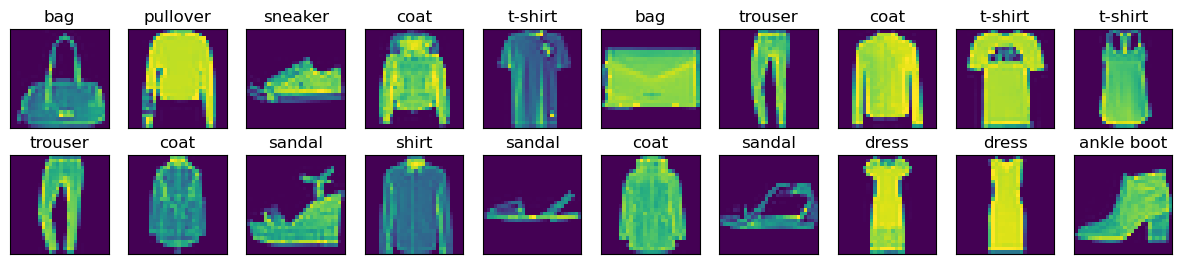

In [24]:
X, y = next(iter(train_iter))
X = X[0:20]
y = y[0:20]
show_images(X.reshape(20, 28, 28), 2, 10, titles=get_fashion_mnist_labels(y));
d2l.plt.show()

# 定义模型

In [27]:
# PyTorch不会隐式地调整输入的形状。
# 因此，我们在线性层前定义了展平层（flatten），来调整网络输入的形状
num_inputs = 784
num_outputs = 10
net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))


# 初始化模型参数

In [28]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
# net.apply() 表示对net的所有模块应用init_weights函数

# 损失函数

In [29]:
loss = nn.CrossEntropyLoss(reduction='none')
# reduction='none'表示不对损失函数的值求平均

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [30]:
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


In [36]:
def accuracy(y_hat, y):
    """
    计算预测中正确的数量。

    参数:
        y_hat (Tensor): 模型预测输出，通常为网络的直接输出（未处理或经过 softmax）。
        y (Tensor): 真实标签，必须与 `y_hat` 的预测标签维度一致。

    返回:
        float: 预测正确的样本数量。

    功能描述:
        - 如果 `y_hat` 是二维张量且包含多个类别（例如分类问题的网络输出），
          使用 `argmax` 找到每行最大值的索引作为预测类别。
        - 比较预测类别与真实类别，统计预测正确的数量。

    示例:
        >>> y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.7, 0.2, 0.1]])
        >>> y = torch.tensor([2, 0])
        >>> print(accuracy(y_hat, y))  # 输出: 2.0
    """
    # 判断预测输出是否为多类别，如果是，选择每行最大值的索引作为预测类别
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    
    # 比较预测类别和真实类别，生成布尔张量，表示每个样本是否预测正确
    cmp = y_hat.type(y.dtype) == y

    # 将布尔张量转换为数值型并求和，得到预测正确的数量
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """
    计算模型在指定数据集上的预测精度。

    参数:
        net (torch.nn.Module 或自定义网络): 要评估的模型。
        data_iter (DataLoader): 数据集的迭代器，提供输入特征和对应的真实标签。

    返回:
        float: 模型在数据集上的预测精度，取值范围为 [0, 1]。

    功能描述:
        - 遍历给定的数据集，逐批计算模型的预测精度。
        - 对于 PyTorch 的 `torch.nn.Module` 类型模型，先切换到评估模式以禁用训练时的特定行为（例如 Dropout）。
        - 使用 `Accumulator` 类（假设已定义）记录正确预测的样本数量和总样本数量。
        - 最终计算正确预测数占总样本数的比例，作为精度指标。

    核心逻辑:
        1. 检查模型类型，并切换到评估模式，确保行为一致。
        2. 在 `torch.no_grad()` 上下文中禁用梯度计算，以提高效率。
        3. 遍历数据集的每一批次，计算该批次中的预测正确数量。
        4. 累加所有批次的正确预测数与总样本数。
        5. 返回正确预测总数与总样本数的比值，表示模型的整体精度。

    示例:
        >>> train_iter, test_iter = load_data_fashion_mnist(batch_size=64)
        >>> test_acc = evaluate_accuracy(net, test_iter)
        >>> print(f"Test Accuracy: {test_acc:.2%}")

    注意:
        - `accuracy` 函数需已定义，负责计算单批次的正确预测数量。
        - `Accumulator` 类需已定义，用于简化累加逻辑。
    """
    if isinstance(net, torch.nn.Module):
        # 设置模型为评估模式，禁用训练时的特定行为（如 Dropout 和 BatchNorm 的动态更新）
        net.eval()
    
    # 初始化累加器: metric[0] 记录正确预测数，metric[1] 记录样本总数
    metric = Accumulator(2)
    
    with torch.no_grad():  # 禁用梯度计算以提高效率
        for X, y in data_iter:
            # 累加当前批次的正确预测数和总样本数
            metric.add(accuracy(net(X), y), y.numel())
            # y.numel() 返回 y 中元素的总数，即样本总数
    
    # 返回精度 = 正确预测数 / 样本总数
    return metric[0] / metric[1]

class Accumulator:
    """
    在多个变量上进行累加操作的工具类。

    功能:
        - 支持对 n 个变量同时进行累加。
        - 提供方法重置累加器或获取特定变量的累加值。

    属性:
        data (list[float]): 用于存储 n 个变量的当前累加值。

    方法:
        - add(*args): 将输入的值逐元素累加到 `data` 中。
        - reset(): 将所有累加器变量重置为 0.0。
        - __getitem__(idx): 返回指定索引变量的累加值。

    示例:
        >>> acc = Accumulator(3)  # 初始化 3 个累加变量
        >>> acc.add(1, 2, 3)  # 累加 (1, 2, 3)
        >>> acc.add(0.5, 0.5, 0.5)  # 累加 (0.5, 0.5, 0.5)
        >>> print(acc[0], acc[1], acc[2])  # 输出: 1.5, 2.5, 3.5
        >>> acc.reset()  # 重置累加器
        >>> print(acc[0])  # 输出: 0.0
    """
    def __init__(self, n):
        """
        初始化一个包含 n 个变量的累加器。

        参数:
            n (int): 累加变量的数量。
        """
        self.data = [0.0] * n

    def add(self, *args):
        """
        将输入的值逐元素累加到对应的累加变量中。

        参数:
            *args: 一个可变参数列表，其长度应与累加变量的数量一致。
                   每个值会累加到对应索引的变量中。

        示例:
            >>> acc = Accumulator(2)
            >>> acc.add(1, 2)  # 累加到两个变量中
            >>> acc.add(0.5, 0.5)
            >>> print(acc[0], acc[1])  # 输出: 1.5, 2.5
        """
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        """
        将所有累加变量重置为 0.0。

        示例:
            >>> acc = Accumulator(2)
            >>> acc.add(1, 2)
            >>> acc.reset()
            >>> print(acc[0])  # 输出: 0.0
        """
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        """
        返回指定索引变量的累加值。

        参数:
            idx (int): 索引值，表示要访问的累加变量。

        返回:
            float: 索引对应变量的当前累加值。

        示例:
            >>> acc = Accumulator(3)
            >>> acc.add(1, 2, 3)
            >>> print(acc[1])  # 输出: 2
        """
        return self.data[idx]

class Animator:
    """
    用于在动画中绘制多条数据曲线。

    参数:
        xlabel (str, optional): x 轴标签。
        ylabel (str, optional): y 轴标签。
        legend (list, optional): 每条曲线的图例，若为 None，则不显示图例。
        xlim (tuple, optional): x 轴的范围，如 (xmin, xmax)。
        ylim (tuple, optional): y 轴的范围，如 (ymin, ymax)。
        xscale (str, optional): x 轴的尺度，默认为 'linear'，也可以是 'log'。
        yscale (str, optional): y 轴的尺度，默认为 'linear'，也可以是 'log'。
        fmts (list, optional): 曲线的格式，如颜色、线型等。
        nrows (int, optional): 图表的行数，默认为 1。
        ncols (int, optional): 图表的列数，默认为 1。
        figsize (tuple, optional): 图表的大小，默认为 (3.5, 2.5)。
    
    功能描述:
        - 该类允许增量绘制多条数据线，并实时更新图表，实现动画效果。
        - 支持自定义图表的各种属性，如坐标轴标签、范围、尺度等。

    核心逻辑:
        1. 初始化时设置图表的尺寸、坐标轴和图例等基本属性。
        2. 每次添加数据时，更新图表中的曲线，且清除旧的图表内容。
        3. 使用 `matplotlib` 实现动画更新，动态绘制数据。
    """

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """
        初始化 Animator 对象，用于实时绘制多条数据曲线。

        参数:
            xlabel (str, optional): x 轴标签。
            ylabel (str, optional): y 轴标签。
            legend (list, optional): 每条曲线的图例。
            xlim (tuple, optional): x 轴的显示范围。
            ylim (tuple, optional): y 轴的显示范围。
            xscale (str, optional): x 轴的尺度。
            yscale (str, optional): y 轴的尺度。
            fmts (list, optional): 曲线的样式。
            nrows (int, optional): 图形的行数。
            ncols (int, optional): 图形的列数。
            figsize (tuple, optional): 图形的大小。
        """
        if legend is None:
            legend = []
        d2l.use_svg_display()  # 使用 SVG 图形进行显示
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        
        if nrows * ncols == 1:
            self.axes = [self.axes, ]  # 如果只有一个图，则转换为列表形式
        
        # 使用 lambda 函数配置坐标轴
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        
        # 初始化数据
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """
        向图表中添加数据点，并更新显示。

        参数:
            x (list or tensor): x 坐标数据。
            y (list or tensor): y 坐标数据。
        
        功能描述:
            - 该方法在每次调用时将新的数据添加到图表中，并清除之前的内容。
            - 支持多个数据集同时绘制，并且可以自定义每个数据集的样式。

        核心逻辑:
            1. 如果 `x` 和 `y` 是单个数值而不是列表或张量，自动转换为列表。
            2. 初始化或更新存储数据的列表。
            3. 清空当前图表，重新绘制所有的数据集。
            4. 更新图表的显示。
        """
        if not hasattr(y, "__len__"):
            y = [y]  # 如果 y 不是列表或张量，则转换为列表
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n  # 如果 x 不是列表或张量，则重复 x 以匹配 y 的长度
        
        # 初始化数据存储容器
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        
        # 更新数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        # 清空图表并重新绘制数据
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        
        self.config_axes()  # 更新坐标轴设置
        display.display(self.fig)  # 显示图形
        display.clear_output(wait=True)  # 清除上次输出，保持实时更新

def train_epoch_ch3(net, train_iter, loss, updater):
    """
    训练模型一个迭代周期（定义见第3章）。

    参数:
        net (torch.nn.Module): 需要训练的模型。
        train_iter (DataLoader): 用于提供训练数据的迭代器。
        loss (function): 用于计算损失的函数。
        updater (function or torch.optim.Optimizer): 优化器，用于更新模型的参数。可以是 PyTorch 内置的优化器，或者自定义的更新函数。

    返回:
        tuple: 训练损失和训练精度。
            - 第一个值为训练损失（float）。
            - 第二个值为训练精度（float）。

    功能描述:
        - 该函数定义了一个完整的训练周期，遍历训练数据集，对每个批次的数据进行前向计算、计算损失、反向传播、参数更新。
        - 通过 `Accumulator` 累积训练过程中每个批次的损失和精度，并返回整个周期的平均损失和精度。
        - 支持使用 PyTorch 内置优化器（如 `torch.optim.SGD`）或自定义优化器来更新参数。

    核心逻辑:
        1. 将模型切换到训练模式。
        2. 遍历训练集数据，并计算每个批次的损失。
        3. 执行反向传播计算梯度。
        4. 使用优化器更新模型的参数。
        5. 累积每个批次的损失和精度，计算训练周期的平均损失和精度。

    示例:
        >>> train_loss, train_acc = train_epoch_ch3(net, train_iter, loss, updater)
        >>> print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    """
    # 将模型设置为训练模式，这将启用 Dropout 和 BatchNorm 等训练专用行为
    if isinstance(net, torch.nn.Module):
        net.train()

    # 初始化累加器，保存训练损失、训练准确度和样本数
    metric = Accumulator(3)

    # 遍历训练数据集
    for X, y in train_iter:
        # 计算模型的预测值
        y_hat = net(X)

        # 计算损失
        l = loss(y_hat, y)

        # 使用PyTorch内置的优化器
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()  # 清除梯度
            l.mean().backward()  # 计算梯度
            updater.step()  # 更新参数
        else:
            # 使用定制的优化器
            l.sum().backward()  # 计算梯度
            updater(X.shape[0])  # 更新参数

        # 累加当前批次的损失、精度和样本数
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度（分别是损失和准确度的平均值）
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """ 
    训练模型并评估其性能，适用于第3章中定义的训练过程。

    参数:
        net (torch.nn.Module): 要训练的神经网络模型。
        train_iter (DataLoader): 用于训练的数据迭代器，提供训练数据和标签。
        test_iter (DataLoader): 用于测试的数据迭代器，提供测试数据和标签。
        loss (function): 用于计算损失的函数（如交叉熵损失）。
        num_epochs (int): 训练的总轮数。
        updater (function or torch.optim.Optimizer): 用于更新模型参数的优化器。
            可以是 PyTorch 的内置优化器（如 `torch.optim.SGD`）或自定义优化器。

    返回:
        None: 该函数直接在训练过程中绘制训练和测试结果的动态图表，并检查最终模型的精度和损失。
    
    功能描述:
        - 该函数执行多个训练周期，每个周期都包括：
            1. 训练模型，计算训练损失和训练准确率。
            2. 在测试集上评估模型的准确率。
        - 通过 `Animator` 类动态绘制训练损失、训练准确率和测试准确率的变化趋势。
        - 在训练结束后，检查训练损失和准确率是否在合理范围内。

    核心逻辑:
        1. 初始化 `Animator` 对象用于绘制图形。
        2. 对每个训练周期（epoch）：
            - 调用 `train_epoch_ch3` 执行一个完整的训练周期，获取训练损失和训练准确率。
            - 使用 `evaluate_accuracy` 计算测试集的准确率。
            - 更新 `Animator` 图表显示训练损失、训练准确率和测试准确率。
        3. 最后，通过 `assert` 语句确保训练损失和准确率在合理范围内，以保证模型的有效性。

    示例:
        >>> train_ch3(net, train_iter, test_iter, loss, num_epochs=10, updater=optimizer)
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        # 训练一个 epoch，获取训练损失和训练准确率
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 在测试集上评估模型的准确率
        test_acc = evaluate_accuracy(net, test_iter)
        # 将当前 epoch 的训练损失、训练准确率和测试准确率添加到图表中
        animator.add(epoch + 1, train_metrics + (test_acc,))
    
    # 获取最后一个 epoch 的训练损失和准确率
    train_loss, train_acc = train_metrics
    
    # 检查训练损失和准确率是否在合理范围内
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


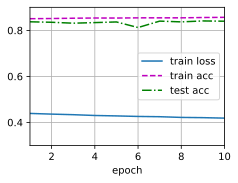

In [39]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)